In [95]:
import numpy as np
import scqubits as scq
import matplotlib.pyplot as plt
from fluxonium_tunable_coupler import *
from functions import *
scq.settings.PROGRESSBAR_DISABLED = True
def FTC_system(
    E_Ja, E_Jb, 
    E_Ca, E_Cb, 
    E_La, E_Lb,
    E_C, ECm, E_L1, E_L2, E_J,
    flux_a, flux_b, flux_c, 
    **kwargs
):
    FTC_grounded = FluxoniumTunableCouplerGrounded(
        EJa=E_Ja, EJb=E_Jb, EC_twoqubit=np.inf,
        ECq1=E_Ca, ECq2=E_Cb, ELa=E_La, ELb=E_Lb,
        flux_a=flux_a, flux_b=flux_b, flux_c=flux_c,
        fluxonium_cutoff=150, fluxonium_truncated_dim=2,
        ECc=E_C, ECm=ECm, EL1=E_L1, EL2=E_L2, EJC=E_J,
        fluxonium_minus_truncated_dim=6, h_o_truncated_dim=4
    )

    return FTC_grounded


In [96]:
EL = 0.4
para_exp = {
    'E_Ja': 5,
    'E_Jb': 4.6,
    'E_Ca': 1.8,
    'E_Cb': 2.1,
    'E_J': 4,
    'E_C': 0.2,
    'ECm': 50,
    'E_L2': 10,
    'E_L1': 10,
    'E_La': EL,
    'E_Lb': EL,
}

# para_exp = {
#     'E_Ja': 4.6,
#     'E_Jb': 5.5,
#     'E_Ca': 0.9,
#     'E_Cb': 0.9,
#     'E_J': 3,
#     'E_C': 16.686114352392064,
#     'ECm': 50,
#     'E_L2': 2,
#     'E_L1': 2,
#     'E_La': 0.21,
#     'E_Lb': 0.21,
# }



In [97]:
from functions import*
FTC_grounded = FTC_system(
    **para_exp,
    flux_a = 0.5,
    flux_b = 0.5,
    flux_c = 0.25,
)
fa = FTC_grounded.fluxonium_a()
fb = FTC_grounded.fluxonium_b()
fm = FTC_grounded.fluxonium_minus()
Ea = (fa.eigenvals() - fa.eigenvals()[0])
Eb = (fb.eigenvals() - fb.eigenvals()[0])
fm_energy = fm.eigenvals()-fm.eigenvals()[0]
anh = fm_energy[2]-2*fm_energy[1]

In [98]:
# FTC_grounded = FTC_system(
#         **para_exp,
#         flux_a=0.5,
#         flux_b=0.5,
#         flux_c=0.25,
#     )
# fm = FTC_grounded.fluxonium_minus()
# Hs,phase_op, omega_s, phi_zpf, g3 = fluxonium_paras(fm.EC, fm.EL, fm.EJ, fm.flux)
# fa = FTC_grounded.fluxonium_a()
# fb = FTC_grounded.fluxonium_b()


In [131]:
import pickle
import sympy as sp

def compute_rates(ftc):
    fa = ftc.fluxonium_a()
    fb = ftc.fluxonium_b()
    fm = ftc.fluxonium_minus()

    E1 = (fa.eigenvals() - fa.eigenvals()[0])[1]
    E2 = (fb.eigenvals() - fb.eigenvals()[0])[1]
    Es = (fm.eigenvals() - fm.eigenvals()[0])[1]
    alpha = (fm.eigenvals() - fm.eigenvals()[0])[2] - 2 * (fm.eigenvals() - fm.eigenvals()[0])[1]
    p = E1 + E2
    d = E2 - E1
    phi101 = fa.phi_operator(energy_esys=True)[0, 1]
    phi201 = fb.phi_operator(energy_esys=True)[0, 1]
    phis = fm.phi_operator(energy_esys=True)
    ns = fm.n_operator(energy_esys=True)
    omega_s = fm.eigensys()[0][1] - fm.eigensys()[0][0]

    with open('x_variable.pkl', 'rb') as file:
        x = pickle.load(file)
    with open('S2.pkl', 'rb') as file:
        x_app = pickle.load(file)

    symbols = {str(symbol): sp.symbols(str(symbol)) for symbol in x.free_symbols}
    symbols_value = symbols.copy()
    symbols_value.update({
        'phi_s02': phis[0, 2],
        'phi_s01': phis[0, 1],
        'E_L': EL,
        'n_12': ns[1, 2] / 1j,
        'omega_s': omega_s,
        'alpha': 0,
        'phi^2_10': phi201,
        'phi_s00': phis[0, 0],
        'epsilon^1_1': E1,
        'epsilon^2_1': E2,
        'phi_s11': phis[1, 1],
        'n_01': ns[0, 1] / 1j,
        'n_02': ns[0, 2] / 1j,
        'phi_s12': phis[1, 2],
        'phi^1_10': phi101,
        'phi_s13': phis[1, 3],
        'phi_s24': phis[2, 4],
        'phi_s23': phis[2, 3],
        'phi_s22': phis[2, 2]
    })

    for key, value in symbols.items():
        x = x.subs(value, symbols_value[key])
    for key, value in symbols.items():
        x_app = x_app.subs(value, symbols_value[key])

    rate0011 = x
    rate0011_app = x_app
    rate0110_app = x_app / p * d
    rate0011 = complex(rate0011)
    rate0011_app = complex(rate0011_app)
    rate0110_app = complex(rate0110_app)
    return rate0011_app, rate0110_app

# Example usage:
rate0011_app, rate0110_app = compute_rates(FTC_grounded)

In [132]:
rate0110_app

0.00039313320342150256j

In [133]:
hs = FTC_grounded.generate_coupled_system_sweetspot()
H0 = (hs.bare_hamiltonian() ).full()
V = hs.interaction_hamiltonian().full()
H0, V = shuffle_matrices(H0, V)
swt_result = swt_subspace(H0, V, [0, 1, 2, 3])
S1,S2,S3 = swt_result[0]
Hc = (scq.identity_wrap(hs['fluxonium_minus'].n_operator(), hs['fluxonium_minus'], hs.subsystem_list)).full()
H0 = (hs.bare_hamiltonian() ).full()
H0, Hc = shuffle_matrices(H0, Hc)
def operantor_trans(S,op):
    S1,S2 = S
    firstorder = commutator(S1,op)
    secondorder =  S2@op - op@S2 +1/2*op@S1@S1 - S1@op@S1 +1/2*S1@S1@op
    return firstorder,secondorder
charge1,charge2 = operantor_trans([S1,S2],Hc)

In [134]:
charge2[0:4,0:4]

array([[0.+3.40143894e-18j, 0.-1.26368115e-17j, 0.-2.28503863e-17j,
        0.+2.22389835e-03j],
       [0.+1.26368115e-17j, 0.+8.61676712e-19j, 0.+4.13974116e-04j,
        0.-3.25262051e-18j],
       [0.+2.28503863e-17j, 0.-4.13974116e-04j, 0.+4.10840655e-20j,
        0.-4.23211592e-18j],
       [0.-2.22389835e-03j, 0.+3.25262051e-18j, 0.+4.23211592e-18j,
        0.+2.21535450e-19j]])

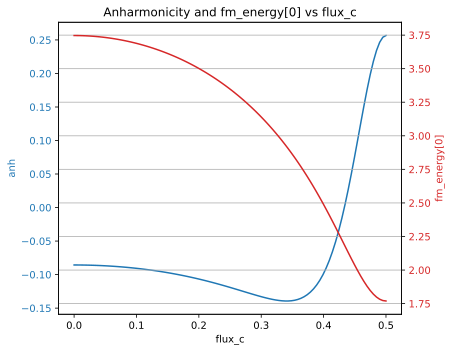

In [135]:
flux_c_values = np.linspace(0, 0.5, 100)
anh_values = []
fm_energy_first_values = []

for flux_c in flux_c_values:
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5,
        flux_b=0.5,
        flux_c=flux_c,
    )
    fm = FTC_grounded.fluxonium_minus()
    fm_energy = fm.eigenvals() - fm.eigenvals()[0]
    anh = fm_energy[2] - 2 * fm_energy[1]
    anh_values.append(anh)
    fm_energy_first_values.append(fm_energy[1])

fig, ax1 = plt.subplots()

ax1.set_xlabel('flux_c')
ax1.set_ylabel('anh', color='tab:blue')
ax1.plot(flux_c_values, anh_values, color='tab:blue', label='Anharmonicity')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('fm_energy[0]', color='tab:red')
ax2.plot(flux_c_values, fm_energy_first_values, color='tab:red', label='fm_energy[0]')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Anharmonicity and fm_energy[0] vs flux_c')
plt.grid(True)
plt.show()

In [136]:
Ea

array([ 0.        ,  0.44512902,  5.78416412,  8.34812771, 11.90664362,
       13.59408618])

In [137]:
Eb

array([ 0.        ,  0.68033813,  5.97278956,  8.96427963, 12.30148858,
       13.7918291 ])

In [138]:
from joblib import Parallel, delayed
from scipy.optimize import minimize

# Define the objective function to minimize the sum of flux_sa and flux_sb
def objective_function(fluxes, flux_c):
    flux_sa, flux_sb = fluxes
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 + flux_sa,
        flux_b=0.5 + flux_sb,
        flux_c=flux_c,
    )
    hs = FTC_grounded.generate_coupled_system_sweetspot()
    H0 = (hs.bare_hamiltonian() ).full()
    V = hs.interaction_hamiltonian().full()
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])

    # Sum the relevant submatrices
    sum_matrix = sum(swt_result[1][i][0:6, 0:6] for i in range(4))

    # Calculate specific matrix elements using np.linalg.norm
    element_sum = (
        np.abs(sum_matrix[0, 1]) +
        np.abs(sum_matrix[0, 2]) +
        np.abs(sum_matrix[1, 3]) +
        np.abs(sum_matrix[2, 3])
    )
    return element_sum
# Define the objective function to minimize the sum of flux_sa and flux_sb

def H_eff(ftc):
    hs = ftc.generate_coupled_system_sweetspot()
    H0 = (hs.bare_hamiltonian() ).full()
    V = hs.interaction_hamiltonian().full()
    H0, V = shuffle_matrices(H0, V)
    swt_result = swt_subspace(H0, V, [0, 1, 2, 3])

    # Sum the relevant submatrices
    sum_matrix = sum(swt_result[1][i][0:6, 0:6] for i in range(4))
    return sum_matrix, H0[0:6, 0:6]

def derivative_matrix(ftc):
    dphi = 1e-6
    flux_a, flux_b, flux_c = ftc.flux_a, ftc.flux_b, ftc.flux_c
    eigenvals = ftc.eigenvals()[1:4] - ftc.eigenvals()[0]  # Store only the second, third, and fourth eigenvalues

    def compute_derivative(flux_a_shift=0, flux_b_shift=0, flux_c_shift=0):
        ftcp = FTC_system(
            **para_exp,
            flux_a=flux_a + flux_a_shift,
            flux_b=flux_b + flux_b_shift,
            flux_c=flux_c + flux_c_shift,
        )
        eigenvals_p = ftcp.eigenvals()[1:4] - ftcp.eigenvals()[0]  # Store only the second, third, and fourth eigenvalues
        return (eigenvals_p - eigenvals) / dphi

    der1 = compute_derivative(flux_a_shift=dphi)
    der2 = compute_derivative(flux_b_shift=dphi)
    der3 = compute_derivative(flux_c_shift=dphi)

    # Print the derivatives in matrix form with labels
    derivative_matrix = np.array([der1, der2, der3]).T

    return derivative_matrix

def matrix_element(ftc):
    hbspace = ftc.generate_coupled_system()
    hbspace.generate_lookup()
    op = hbspace.op_in_dressed_eigenbasis(op_callable_or_tuple=hbspace["fluxonium_minus"].n_operator).full()
    return op[0:4,0:4]

def matrix_elementapp(ftc):
    hbspace = ftc.generate_coupled_system()
    hbspace.generate_lookup()
    op = hbspace.op_in_dressed_eigenbasis(op_callable_or_tuple=hbspace["fluxonium_minus"].n_operator).full()
    return op[0:4,0:4]

def compute_eigenvals_for_flux_c(flux_c):
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5,
        flux_b=0.5,
        flux_c=flux_c,
    )
    flux_sa, flux_sb = FTC_grounded.find_flux_shift()
    initial_guess = [flux_sa, flux_sb]
    bounds = [(flux_sa - 0.01, flux_sa + 0.01), (flux_sb - 0.01, flux_sb + 0.01)]
    
    result = minimize(objective_function, initial_guess, args=(flux_c,), method='Nelder-Mead', bounds=bounds, options={'disp': True})

    optimized_flux_sa, optimized_flux_sb = result.x
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 + optimized_flux_sa, 
        flux_b=0.5 + optimized_flux_sb,
        flux_c=flux_c,
    )
    eigenvals = FTC_grounded.eigenvals()
    eigenvals = eigenvals[:4] - eigenvals[0]  # Ensure compatible shapes

    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 + optimized_flux_sa,
        flux_b=0.5 + optimized_flux_sb,
        flux_c=flux_c,
    )
    # Sum the relevant submatrices
    sum_matrix, H0 = H_eff(FTC_grounded)
    der_mat = derivative_matrix(FTC_grounded)
    drive = matrix_element(FTC_grounded)
    drive_app = matrix_elementapp(FTC_grounded)
    return eigenvals, H0[0:6, 0:6], sum_matrix, der_mat,drive



In [139]:
# Generate flux_c values
flux_c_values = np.linspace(0.1, 0.4, 10)


In [23]:

# Generate flux_c values
flux_c_values = np.linspace(0.1, 0.4, 10)

# Use joblib to parallelize the computation
result = Parallel(n_jobs=-1)(delayed(compute_eigenvals_for_flux_c)(flux_c) for flux_c in flux_c_values)

In [27]:
# Separate the result into evals_array and H_eff_array
eigenvalues = np.array([res[0] for res in result])
H_eff_array = np.array([res[2] for res in result])
H0_array = np.array([res[1] for res in result])
der_matrices = np.array([res[3] for res in result])
drives = np.array([res[4] for res in result])
# # Make diagonal elements of H_eff to be 0 and keep others
# # for H_eff in H_eff_array:
# #     H_eff[np.diag_indices_from(H_eff)] = 0

# # Diagonalize each H_eff and plot the corresponding lowest 4 levels
# eigenvalues = np.array([np.linalg.eigvalsh(H_eff + H0)[:4] for H_eff, H0 in zip(H_eff_array, H0_array)])

# # Subtract the first element from each eigenvalues array
# for i in range(eigenvalues.shape[0]):
#     eigenvalues[i] -= eigenvalues[i, 0]
# # Plot the lowest 4 levels
# for i in range(4):
#     plt.plot(flux_c_values, eigenvalues[:, i], label=f'Level {i}')
# plt.xlabel('flux_c')
# plt.ylabel('Energy')
# plt.legend()
# plt.show()

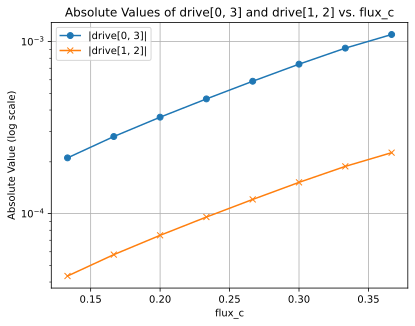

In [28]:
# Extract the [0][3] and [1][2] elements from each matrix in drives
elements_03 = np.array([np.abs(drive[0, 3]) for drive in drives])
elements_12 = np.array([np.abs(drive[1, 2]) for drive in drives])

# Plot the absolute values of the extracted elements against flux_c_values in log scale, excluding the first and last points
plt.plot(flux_c_values[1:-1], elements_03[1:-1], marker='o', linestyle='-', label='|drive[0, 3]|')
plt.plot(flux_c_values[1:-1], elements_12[1:-1], marker='x', linestyle='-', label='|drive[1, 2]|')
plt.xlabel('flux_c')
plt.ylabel('Absolute Value (log scale)')
plt.title('Absolute Values of drive[0, 3] and drive[1, 2] vs. flux_c')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# plt.plot(flux_c_values, eigenvalues[:, 2], label=f'Level {1}')
# plt.show()
# plt.plot(flux_c_values, eigenvalues[:, 1], label=f'Level {1}')
# plt.show()

In [30]:
der_matrices[5]

array([[-0.00139097,  0.0048911 , -0.00899759],
       [-0.00052055,  0.00354568, -0.01535521],
       [ 0.00123296,  0.00084911, -0.02486948]])

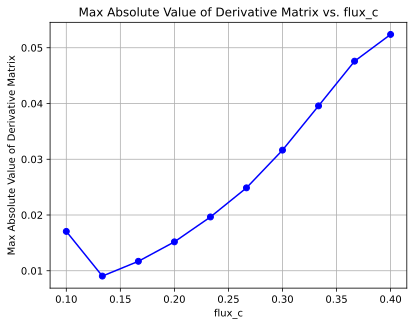

In [31]:
max_abs_values = np.max(np.abs(der_matrices), axis=(1, 2))
plt.plot(flux_c_values, max_abs_values, marker='o', linestyle='-', color='b')
plt.xlabel('flux_c')
plt.ylabel('Max Absolute Value of Derivative Matrix')
plt.title('Max Absolute Value of Derivative Matrix vs. flux_c')
plt.grid(True)
plt.show()

In [32]:
# Plot the matrix elements of H_eff for the 00-11 and 01-10 transitions
# plt.plot(flux_c_values, np.real(H_eff_array[:,0,3]) , label='00-11')
# plt.plot(flux_c_values, 
#          np.real(H_eff_array[:,1,2]) , label='01-10')
# plt.legend()
# plt.show()
# # plot the matrix elements of H_eff for the 00-01, 00-10, 10-11, and 01-11 transitions, i.e effective sigmax operator for each qubit
# plt.plot(flux_c_values, np.real(H_eff_array[:,0,1]) , label='00-01')
# plt.plot(flux_c_values, np.real(H_eff_array[:,0,2]) , label='00-10')
# plt.plot(flux_c_values, -np.real(H_eff_array[:,1,3]) , label='10-11')
# plt.plot(flux_c_values, -np.real(H_eff_array[:,2,3]) , label='11-01')
# plt.legend()
# plt.show()


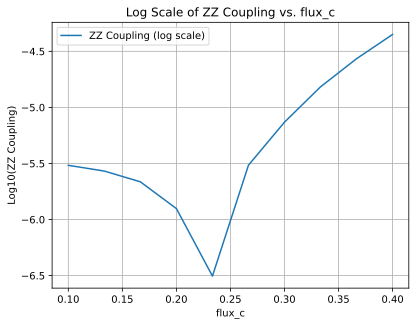

In [33]:
# Calculate the ZZ coupling
zz_coupling = np.abs(eigenvalues[:, 3] - eigenvalues[:, 2] - eigenvalues[:, 1])

# Plot the log scale of its absolute value
plt.plot(flux_c_values, np.log10(zz_coupling), label='ZZ Coupling (log scale)')
plt.xlabel('flux_c')
plt.ylabel('Log10(ZZ Coupling)')
plt.title('Log Scale of ZZ Coupling vs. flux_c')
plt.grid(True)
plt.legend()
plt.show()